In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn 
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

import clip

## data visualization

In [2]:
import deeplake
from torchvision import transforms, models

ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

batch_size = 8

tform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    # transforms.Normalize([0.5], [0.5]),
])

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

c:\Users\alllh\anaconda3\envs\dev\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.2.15) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/pacs-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train
hub://activeloop/pacs-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test


In [3]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


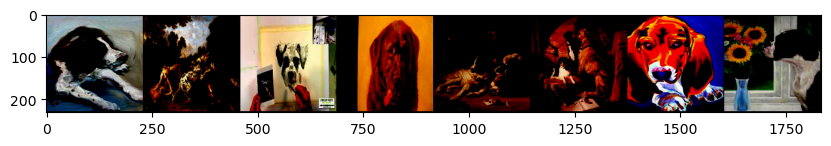

torch.Size([8, 3, 227, 227])


In [7]:
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)

## load data

In [34]:
import pickle

## load pickle
with open('class_tokens.pickle', 'rb') as fr:
    class_tokens = pickle.load(fr)
with open('class_features.pickle', 'rb') as fr:
    class_features = pickle.load(fr)

In [35]:
with open('train_image_features_list.pickle', 'rb') as fr:
    train_image_features_list = pickle.load(fr)
with open('train_labels_list.pickle', 'rb') as fr:
    train_labels_list = pickle.load(fr)
with open('test_image_features_list.pickle', 'rb') as fr:
    test_image_features_list = pickle.load(fr)
with open('test_labels_list.pickle', 'rb') as fr:
    test_labels_list = pickle.load(fr)

#### Model

In [36]:
# Define model
class OurCLIP(nn.Module):        
    def __init__(self, clip_model, # use pre-trained clip model
                 use_one_ln1=True, use_one_ln2=True, 
                 use_one_projection1=True, use_one_projection2=True,
                 projection_random_init1=False, 
                 projection_random_init2=False, 
                 trainable_ln1=False, trainable_ln2=False, 
                 trainable_projection1=False, trainable_projection2=False,
                 threshold = 100, score_type=0): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.threshold = threshold
        self.score_type = score_type

        self.threshold_weight = nn.Parameter(torch.rand(1)).requires_grad_(True)

        ####################### 미구현
        if use_one_ln1:
            self.ln_post = clip_model.visual.ln_post.requires_grad_(trainable_ln1)
        else: pass
        if use_one_ln2:
            self.ln_final = clip_model.ln_final.requires_grad_(trainable_ln2)
        else: pass
        ########################

        if use_one_projection1:
            self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(trainable_projection1)
        else:
            if projection_random_init1:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.visual.proj, dtype=torch.float16).normal_(mean=0,std=0.03),
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
            else:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
        
        if use_one_projection2:
            self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(trainable_projection2)
        else:
            if projection_random_init2:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        torch.zeros_like(clip_model.text_projection, dtype=torch.float16).normal_(mean=0,std=0.03),
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)
            else:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)


    def forward(self, image_features, class_features, class_tokens):    
        image_features2 = self.ln_post(image_features)                      # (12, batch_size, 768)
        image_embeddings = image_features2 @ self.visual_projection         # (12, batch_size, 512)  <- we'll use it

        class_features2 = self.ln_final(class_features).type(self.dtype)    # (12, seq_len, 77, 512)
        class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), 
                                           class_tokens.argmax(dim=-1)] @ self.textual_projection
                                                                            # (12, seq_len, 512)  <- we'll use it

        score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
        if self.score_type != 3:
            score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

        if self.score_type == 1:
            return torch.mean(score_tensor, dim=-1)
        if self.score_type == 2:
            return torch.sigmoid(100 * (score_tensor-(self.threshold*self.threshold_weight))).sum(dim=-1)
        if self.score_type == 3:
            return score_tensor.max(dim=-1)[0].mean(dim=-1)
        return torch.max(score_tensor, dim=-1)[0]

## Train

In [37]:
import time
import torch.nn.functional as f

def train_one_epoch(model, optimizer, criterion, image_features_list, labels_list, max_iter_num=3000, print_log=True):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i in range(len(image_features_list)):
        image_features = image_features_list[i]
        labels = labels_list[i]
        
        optimizer.zero_grad()
        
        output = model(image_features, class_features, class_tokens)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()

        if print_log:
            if i != 0 and i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' % (i, running_loss, speed, accuracy))

                running_loss = 0.0
                total = 0
                correct = 0

        if i != 0 and i % max_iter_num == 0:
            break;
    
    return accuracy

    
def test_model(model, image_features_list, labels_list, max_iter_num=1000, print_log=True):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(image_features_list)):
            image_features = image_features_list[i]
            labels = labels_list[i]

            # forward + backward + optimize
            output = model(image_features, class_features, class_tokens)

            predicted = torch.argmax(output, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            if i != 0 and i % max_iter_num == 0:
                break
            
        accuracy = 100 * correct / total

        if print_log:
            print('Finished Testing')
            print('Testing accuracy: %.1f %%' %(accuracy))
            
    return accuracy

In [38]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.accuracy = 0
        self.patience = 0
        self.patience_limit = patience
        
    def step(self, accuracy):
        if self.accuracy < accuracy:
            self.accuracy = accuracy
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

In [39]:
def start_train(model, criterion, optimizer, num_epochs=200, patience=5, 
                save_path='output0316.txt', save_content='', print_log=True):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    early_stop = EarlyStopping(patience)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        print("------------------ Training Epoch {} ------------------".format(epoch+1))
        train_accuracy = train_one_epoch(model, optimizer, criterion, 
                                        train_image_features_list, train_labels_list, max_iter_num=1000, print_log=print_log)
        test_accuracy = test_model(model, test_image_features_list, test_labels_list, print_log=print_log)
        print(f"train accuracy: {train_accuracy:.2f}%\ttest accuracy: {test_accuracy:.2f}%")

        early_stop.step(test_accuracy)
        if early_stop.is_stop():
            print(f"-\ntrain epoch: {epoch}")
            break

    with open(save_path, 'a') as f:
        f.write(f"{epoch+1}\t"+"="*10+f"{save_content}\n")
        f.write(f"accuracy: {test_accuracy:.4f}\n")


    print('Finished Training')

### inference

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

num_epochs = 400
patience = 5

In [41]:
# train all by one tensor / max_score
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='train all by one tensor / max_score', print_log=False)

torch.save(model.state_dict(), 'saved/oneMaxModel.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 96.16%	test accuracy: 91.97%
------------------ Training Epoch 2 ------------------
train accuracy: 97.66%	test accuracy: 91.79%
------------------ Training Epoch 3 ------------------
train accuracy: 98.02%	test accuracy: 91.85%
------------------ Training Epoch 4 ------------------
train accuracy: 98.28%	test accuracy: 92.10%
------------------ Training Epoch 5 ------------------
train accuracy: 98.40%	test accuracy: 92.30%
------------------ Training Epoch 6 ------------------
train accuracy: 98.51%	test accuracy: 92.37%
------------------ Training Epoch 7 ------------------
train accuracy: 98.61%	test accuracy: 92.41%
------------------ Training Epoch 8 ------------------
train accuracy: 98.69%	test accuracy: 92.39%
------------------ Training Epoch 9 ------------------
train accuracy: 98.79%	test accuracy: 92.47%
------------------ Training Epoch 10 ------------------
train accuracy: 98.86%	test accuracy: 92.53%

In [42]:
# # train all by one tensor / mean_score
# clip_model, preprocess = clip.load("ViT-B/32", device=device)
# model = OurCLIP(clip_model, 
#                 trainable_projection1=True, trainable_projection2=True,
#                 score_type=1).to(device)

# # for name, param in model.named_parameters():
# #     if param.requires_grad:
# #         print(name, param.shape)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

# start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
#             save_path='output0316.txt', save_content='train all by one tensor / mean_score', print_log=False)

In [43]:
# train all by one tensor / new_score
# reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.shape)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='train all by one tensor / new_score', print_log=False)

torch.save(model.state_dict(), 'saved/oneNewModel.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 74.76%	test accuracy: 44.61%
------------------ Training Epoch 2 ------------------
train accuracy: 93.04%	test accuracy: 71.93%
------------------ Training Epoch 3 ------------------
train accuracy: 94.78%	test accuracy: 75.43%
------------------ Training Epoch 4 ------------------
train accuracy: 95.82%	test accuracy: 77.86%
------------------ Training Epoch 5 ------------------
train accuracy: 96.36%	test accuracy: 79.01%
------------------ Training Epoch 6 ------------------
train accuracy: 96.56%	test accuracy: 79.85%
------------------ Training Epoch 7 ------------------
train accuracy: 96.70%	test accuracy: 80.56%
------------------ Training Epoch 8 ------------------
train accuracy: 96.89%	test accuracy: 81.51%
------------------ Training Epoch 9 ------------------
train accuracy: 96.98%	test accuracy: 82.29%
------------------ Training Epoch 10 ------------------
train accuracy: 97.06%	test accuracy: 83.72%

In [44]:
# train all by each tensor(init with last weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.shape)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='train all by each tensor(init with last weight) / max_score',
            print_log=False)

torch.save(model.state_dict(), 'saved/allMaxModel.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 96.15%	test accuracy: 92.16%
------------------ Training Epoch 2 ------------------
train accuracy: 97.71%	test accuracy: 91.85%
------------------ Training Epoch 3 ------------------
train accuracy: 98.01%	test accuracy: 91.85%
------------------ Training Epoch 4 ------------------
train accuracy: 98.33%	test accuracy: 92.14%
------------------ Training Epoch 5 ------------------
train accuracy: 98.40%	test accuracy: 92.37%
------------------ Training Epoch 6 ------------------
train accuracy: 98.50%	test accuracy: 92.43%
------------------ Training Epoch 7 ------------------
train accuracy: 98.57%	test accuracy: 92.38%
------------------ Training Epoch 8 ------------------
train accuracy: 98.70%	test accuracy: 92.37%
------------------ Training Epoch 9 ------------------
train accuracy: 98.77%	test accuracy: 92.48%
------------------ Training Epoch 10 ------------------
train accuracy: 98.84%	test accuracy: 92.51%

In [45]:
# # train all by each tensor(init with last weight) / mean_score
# clip_model, preprocess = clip.load("ViT-B/32", device=device)
# model = OurCLIP(clip_model, 
#                 use_one_projection1=False, use_one_projection2=False,
#                 trainable_projection1=True, trainable_projection2=True,
#                 score_type=1).to(device)

# # for name, param in model.named_parameters():
# #     if param.requires_grad:
# #         print(name, param.shape)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

# start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
#             save_path='output0316.txt', save_content='train all by each tensor(init with last weight) / mean_score',
#             print_log=False)

In [46]:
# train all by each tensor(init with last weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.shape)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='train all by each tensor(init with last weight) / new_score',
            print_log=False)

torch.save(model.state_dict(), 'saved/allNewModel.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 65.75%	test accuracy: 28.85%
------------------ Training Epoch 2 ------------------
train accuracy: 83.61%	test accuracy: 42.74%
------------------ Training Epoch 3 ------------------
train accuracy: 89.68%	test accuracy: 48.64%
------------------ Training Epoch 4 ------------------
train accuracy: 92.36%	test accuracy: 56.28%
------------------ Training Epoch 5 ------------------
train accuracy: 93.62%	test accuracy: 62.09%
------------------ Training Epoch 6 ------------------
train accuracy: 94.17%	test accuracy: 66.82%
------------------ Training Epoch 7 ------------------
train accuracy: 94.80%	test accuracy: 71.58%
------------------ Training Epoch 8 ------------------
train accuracy: 95.24%	test accuracy: 77.51%
------------------ Training Epoch 9 ------------------
train accuracy: 95.57%	test accuracy: 80.61%
------------------ Training Epoch 10 ------------------
train accuracy: 95.78%	test accuracy: 82.09%

In [47]:
# train all by each tensor(init with randn weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=0).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.shape)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='train all by each tensor(init with randn weight) / max_score',
            print_log=False)

torch.save(model.state_dict(), 'saved/allMaxRandInitModel.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 96.01%	test accuracy: 92.57%
------------------ Training Epoch 2 ------------------
train accuracy: 97.71%	test accuracy: 92.05%
------------------ Training Epoch 3 ------------------
train accuracy: 98.01%	test accuracy: 92.05%
------------------ Training Epoch 4 ------------------
train accuracy: 98.31%	test accuracy: 92.27%
------------------ Training Epoch 5 ------------------
train accuracy: 98.38%	test accuracy: 92.45%
------------------ Training Epoch 6 ------------------
train accuracy: 98.51%	test accuracy: 92.45%
-
train epoch: 5
Finished Training


In [48]:
# # train all by each tensor(init with randn weight) / mean_score
# clip_model, preprocess = clip.load("ViT-B/32", device=device)
# model = OurCLIP(clip_model, 
#                 use_one_projection1=False, use_one_projection2=False,
#                 trainable_projection1=True, trainable_projection2=True,
#                 projection_random_init1=True,
#                 projection_random_init2=True,
#                 score_type=1).to(device)

# # for name, param in model.named_parameters():
# #     if param.requires_grad:
# #         print(name, param.shape)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

# start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
#             save_path='output0316.txt', save_content='train all by each tensor(init with randn weight) / mean_score',
#             print_log=False)

In [49]:
# train all by each tensor(init with randn weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=3).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.shape)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

start_train(model, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='train all by each tensor(init with randn weight) / new_score',
            print_log=False)

torch.save(model.state_dict(), 'saved/allNewRandInitModel.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 83.36%	test accuracy: 28.73%
------------------ Training Epoch 2 ------------------
train accuracy: 91.92%	test accuracy: 53.83%
------------------ Training Epoch 3 ------------------
train accuracy: 94.59%	test accuracy: 64.28%
------------------ Training Epoch 4 ------------------
train accuracy: 95.44%	test accuracy: 75.37%
------------------ Training Epoch 5 ------------------
train accuracy: 96.19%	test accuracy: 75.67%
------------------ Training Epoch 6 ------------------
train accuracy: 96.34%	test accuracy: 81.29%
------------------ Training Epoch 7 ------------------
train accuracy: 96.77%	test accuracy: 83.62%
------------------ Training Epoch 8 ------------------
train accuracy: 96.91%	test accuracy: 85.15%
------------------ Training Epoch 9 ------------------
train accuracy: 97.10%	test accuracy: 87.08%
------------------ Training Epoch 10 ------------------
train accuracy: 97.19%	test accuracy: 87.21%

## Zeroshot Clip model

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [10]:
with open('train_labels_list0.pickle', 'rb') as fr:
    train_labels_list0 = pickle.load(fr)
with open('train_images_feature_list.pickle', 'rb') as fr:
    train_images_feature_list = pickle.load(fr)
with open('test_labels_list0.pickle', 'rb') as fr:
    test_labels_list0 = pickle.load(fr)
with open('test_images_feature_list.pickle', 'rb') as fr:
    test_images_feature_list = pickle.load(fr)
with open('class_features0.pickle', 'rb') as fr:
    class_features0 = pickle.load(fr)

In [76]:
class _CLIP(nn.Module):        
    def __init__(self, clip_model): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(True)
        self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(True)
        ####################### 학습할지 여부 결정하지 않았음
        self.ln_post = clip_model.visual.ln_post.requires_grad_(False)
        self.ln_final = clip_model.ln_final.requires_grad_(False)
        ########################
        self.logit_scale = clip_model.logit_scale

    def forward(self, image_features, class_features, class_tokens):
        image_features = self.ln_post(image_features)                       # (batch_size, 768)
        image_features = image_features @ self.visual_projection            # (batch_size, 512)  <- we'll use it

        class_features = self.ln_final(class_features).type(self.dtype)     # (seq_len, 77, 512)
        class_features = class_features[torch.arange(class_features.shape[0]), 
                                           class_tokens.argmax(dim=-1)] @ self.textual_projection
                                                                            # (seq_len, 512)  <- we'll use it

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        class_features = class_features / class_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ class_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text

In [67]:
# zeroshot
def test_model_for_clip_model(model, images_feature_list, labels_list, max_iter_num=1000):

    model.eval()

    total = 0
    correct = 0

    with torch.no_grad():
        for i in range(len(labels_list)):
            image_features = images_feature_list[i]
            labels = labels_list[i]

            # forward + backward + optimize
            outputs = model(image_features, class_features0, class_tokens)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i != 0 and i % max_iter_num == 0:
                break

        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.2f %%' %(accuracy))

    return accuracy

In [68]:
model = _CLIP(clip_model)

accuracy = test_model_for_clip_model(model, test_images_feature_list, test_labels_list0)

with open("output0316.txt", 'a') as f:
    f.write("="*10+"clip / zeroshot\n")
    f.write(f"accuracy: {accuracy:.4f}\n")

Finished Testing
Testing accuracy: 91.78 %


# Linear probing model

In [69]:
def train_model_for_clip_model(model, optimizer, criterion, images_feature_list, labels_list, max_iter_num=3000, print_log=True):

    model.train()

    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i in range(len(labels_list)):
        image_features = images_feature_list[i]
        labels = labels_list[i]

        # forward + backward + optimize
        outputs = model(image_features, class_features0, class_tokens)[0].softmax(dim=-1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(outputs, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()

        if print_log:
            if i != 0 and i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                    (i, running_loss, speed, accuracy))

                running_loss = 0.0
                total = 0
                correct = 0

        if i != 0 and i % max_iter_num == 0:
            break;
    
    return accuracy

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

model = _CLIP(clip_model)
model.logit_scale.requires_grad_(False)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape, param.requires_grad)

visual_projection torch.Size([768, 512]) True
textual_projection torch.Size([512, 512]) True


In [71]:
patience = 5
num_epochs = 200

In [75]:
import time

model = _CLIP(clip_model)
model.logit_scale.requires_grad_(False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.1)   # lr이 .00001보다 작을 경우 학습이 망가짐

early_stop = EarlyStopping(patience)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_accuracy = train_model_for_clip_model(model, optimizer, criterion,
                                                train_images_feature_list, train_labels_list0, max_iter_num=1000, print_log=True)
    test_accuracy = test_model_for_clip_model(model, test_images_feature_list, test_labels_list0)
    print(f"train accuracy: {train_accuracy:.2f}%\ttest accuracy: {test_accuracy:.2f}%")

    early_stop.step(test_accuracy)

    if early_stop.is_stop():
        print(f"-\ntrain epoch: {epoch}")
        break

with open("output0316.txt", 'a') as f:
    f.write(f"{epoch+1}\t"+"="*10+f"clip linear probing\n")
    f.write(f"accuracy: {test_accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 14.671, speed: 300.15, accuracy: 85.80 %
[   20] loss: 13.068, speed: 310.23, accuracy: 88.12 %
[   30] loss: 12.117, speed: 299.54, accuracy: 97.50 %
[   40] loss: 12.364, speed: 295.63, accuracy: 95.31 %
[   50] loss: 13.354, speed: 295.16, accuracy: 85.62 %
[   60] loss: 13.675, speed: 292.69, accuracy: 85.00 %
[   70] loss: 19.063, speed: 295.86, accuracy: 25.00 %
[   80] loss: 19.131, speed: 305.99, accuracy: 23.12 %
[   90] loss: 19.228, speed: 315.46, accuracy: 23.44 %
[  100] loss: 18.929, speed: 322.92, accuracy: 26.25 %
[  110] loss: 18.845, speed: 330.42, accuracy: 27.19 %
[  120] loss: 19.152, speed: 336.71, accuracy: 24.69 %
[  130] loss: 19.250, speed: 342.94, accuracy: 23.75 %
[  140] loss: 19.249, speed: 347.32, accuracy: 23.44 %
[  150] loss: 18.307, speed: 350.85, accuracy: 32.81 %
[  160] loss: 17.706, speed: 352.10, accuracy: 40.31 %
[  170] loss: 17.388, speed: 354.79, accuracy: 43.44 %
[  180] lo

## LR -> 0.00001

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

oneMaxModel = OurCLIP(clip_model, trainable_projection1=True, trainable_projection2=True, score_type=0).to(device)
oneMaxModel.load_state_dict(torch.load('saved/oneMaxModel.pt'))
oneNewModel = OurCLIP(clip_model, trainable_projection1=True, trainable_projection2=True, score_type=3).to(device)
oneNewModel.load_state_dict(torch.load('saved/oneNewModel.pt'))
allMaxModel = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)
allMaxModel.load_state_dict(torch.load('saved/allMaxModel.pt'))
allNewModel = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)
allNewModel.load_state_dict(torch.load('saved/allNewModel.pt'))
allMaxRandInitModel = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=0).to(device)
allMaxRandInitModel.load_state_dict(torch.load('saved/allMaxRandInitModel.pt'))
allNewRandInitModel = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=3).to(device)
allNewRandInitModel.load_state_dict(torch.load('saved/allNewRandInitModel.pt'))

<All keys matched successfully>

In [51]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(oneMaxModel.parameters(), lr=0.00001, momentum=0.1)

start_train(oneMaxModel, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='oneMaxModel / lr=0.00001',
            print_log=False)

torch.save(model.state_dict(), 'saved/oneMaxModelFT.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 95.76%	test accuracy: 96.46%
------------------ Training Epoch 2 ------------------
train accuracy: 96.89%	test accuracy: 97.04%
------------------ Training Epoch 3 ------------------
train accuracy: 97.24%	test accuracy: 97.26%
------------------ Training Epoch 4 ------------------
train accuracy: 97.40%	test accuracy: 97.39%
------------------ Training Epoch 5 ------------------
train accuracy: 97.53%	test accuracy: 97.41%
------------------ Training Epoch 6 ------------------
train accuracy: 97.49%	test accuracy: 97.42%
------------------ Training Epoch 7 ------------------
train accuracy: 97.46%	test accuracy: 97.36%
------------------ Training Epoch 8 ------------------
train accuracy: 97.53%	test accuracy: 97.32%
------------------ Training Epoch 9 ------------------
train accuracy: 97.55%	test accuracy: 97.35%
------------------ Training Epoch 10 ------------------
train accuracy: 97.58%	test accuracy: 97.39%

In [52]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(oneNewModel.parameters(), lr=0.00001, momentum=0.1)

start_train(oneNewModel, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='oneNewModel / lr=0.00001',
            print_log=False)

torch.save(model.state_dict(), 'saved/oneNewModelFT.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 93.71%	test accuracy: 93.92%
------------------ Training Epoch 2 ------------------
train accuracy: 94.49%	test accuracy: 94.66%
------------------ Training Epoch 3 ------------------
train accuracy: 95.09%	test accuracy: 95.22%
------------------ Training Epoch 4 ------------------
train accuracy: 95.53%	test accuracy: 95.49%
------------------ Training Epoch 5 ------------------
train accuracy: 95.71%	test accuracy: 95.85%
------------------ Training Epoch 6 ------------------
train accuracy: 96.08%	test accuracy: 96.09%
------------------ Training Epoch 7 ------------------
train accuracy: 96.23%	test accuracy: 96.18%
------------------ Training Epoch 8 ------------------
train accuracy: 96.32%	test accuracy: 96.18%
------------------ Training Epoch 9 ------------------
train accuracy: 96.42%	test accuracy: 96.32%
------------------ Training Epoch 10 ------------------
train accuracy: 96.55%	test accuracy: 96.38%

In [53]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(allMaxModel.parameters(), lr=0.00001, momentum=0.1)

start_train(allMaxModel, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='allMaxModel / lr=0.00001',
            print_log=False)

torch.save(model.state_dict(), 'saved/allMaxModelFT.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 94.33%	test accuracy: 95.31%
------------------ Training Epoch 2 ------------------
train accuracy: 95.95%	test accuracy: 96.39%
------------------ Training Epoch 3 ------------------
train accuracy: 96.54%	test accuracy: 96.65%
------------------ Training Epoch 4 ------------------
train accuracy: 96.80%	test accuracy: 96.84%
------------------ Training Epoch 5 ------------------
train accuracy: 96.99%	test accuracy: 96.99%
------------------ Training Epoch 6 ------------------
train accuracy: 97.03%	test accuracy: 97.00%
------------------ Training Epoch 7 ------------------
train accuracy: 97.04%	test accuracy: 97.03%
------------------ Training Epoch 8 ------------------
train accuracy: 97.01%	test accuracy: 97.02%
------------------ Training Epoch 9 ------------------
train accuracy: 97.07%	test accuracy: 97.03%
------------------ Training Epoch 10 ------------------
train accuracy: 97.07%	test accuracy: 97.02%

In [54]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(allNewModel.parameters(), lr=0.00001, momentum=0.1)

start_train(allNewModel, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='allNewModel / lr=0.00001',
            print_log=False)

torch.save(model.state_dict(), 'saved/allNewModelFT.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 91.66%	test accuracy: 92.22%
------------------ Training Epoch 2 ------------------
train accuracy: 92.60%	test accuracy: 93.13%
------------------ Training Epoch 3 ------------------
train accuracy: 93.28%	test accuracy: 93.50%
------------------ Training Epoch 4 ------------------
train accuracy: 93.58%	test accuracy: 93.73%
------------------ Training Epoch 5 ------------------
train accuracy: 93.85%	test accuracy: 93.80%
------------------ Training Epoch 6 ------------------
train accuracy: 93.77%	test accuracy: 93.84%
------------------ Training Epoch 7 ------------------
train accuracy: 94.04%	test accuracy: 93.97%
------------------ Training Epoch 8 ------------------
train accuracy: 94.07%	test accuracy: 94.08%
------------------ Training Epoch 9 ------------------
train accuracy: 94.14%	test accuracy: 94.11%
------------------ Training Epoch 10 ------------------
train accuracy: 94.16%	test accuracy: 94.17%

In [55]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(allMaxRandInitModel.parameters(), lr=0.00001, momentum=0.1)

start_train(allMaxRandInitModel, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='allMaxRandInitModel / lr=0.00001',
            print_log=False)

torch.save(model.state_dict(), 'saved/allMaxRandInitModelFT.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 93.43%	test accuracy: 94.33%
------------------ Training Epoch 2 ------------------
train accuracy: 94.72%	test accuracy: 95.06%
------------------ Training Epoch 3 ------------------
train accuracy: 95.25%	test accuracy: 95.32%
------------------ Training Epoch 4 ------------------
train accuracy: 95.42%	test accuracy: 95.50%
------------------ Training Epoch 5 ------------------
train accuracy: 95.66%	test accuracy: 95.67%
------------------ Training Epoch 6 ------------------
train accuracy: 95.73%	test accuracy: 95.68%
------------------ Training Epoch 7 ------------------
train accuracy: 95.83%	test accuracy: 95.74%
------------------ Training Epoch 8 ------------------
train accuracy: 95.86%	test accuracy: 95.84%
------------------ Training Epoch 9 ------------------
train accuracy: 95.98%	test accuracy: 95.88%
------------------ Training Epoch 10 ------------------
train accuracy: 95.98%	test accuracy: 96.00%

In [56]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(allNewRandInitModel.parameters(), lr=0.00001, momentum=0.1)

start_train(allNewRandInitModel, criterion, optimizer, num_epochs=num_epochs, patience=patience,
            save_path='output0316.txt', save_content='allNewRandInitModel / lr=0.00001',
            print_log=False)

torch.save(model.state_dict(), 'saved/allNewRandInitModelFT.pt')

------------------ Training Epoch 1 ------------------
train accuracy: 92.27%	test accuracy: 92.53%
------------------ Training Epoch 2 ------------------
train accuracy: 92.58%	test accuracy: 92.87%
------------------ Training Epoch 3 ------------------
train accuracy: 92.86%	test accuracy: 93.09%
------------------ Training Epoch 4 ------------------
train accuracy: 93.12%	test accuracy: 93.20%
------------------ Training Epoch 5 ------------------
train accuracy: 93.29%	test accuracy: 93.42%
------------------ Training Epoch 6 ------------------
train accuracy: 93.47%	test accuracy: 93.66%
------------------ Training Epoch 7 ------------------
train accuracy: 93.75%	test accuracy: 93.89%
------------------ Training Epoch 8 ------------------
train accuracy: 93.96%	test accuracy: 94.07%
------------------ Training Epoch 9 ------------------
train accuracy: 94.07%	test accuracy: 94.15%
------------------ Training Epoch 10 ------------------
train accuracy: 94.22%	test accuracy: 94.35%